# Vibration Folder Analysis with Pandas
Steve Embleton | 20170113

This notebook will explore how to create a generic program to analyize vibration data.  Using a calibration run that recorded the ESI truck vibration profile for testing purposes.  

### Goals
* Import CSV data
* Find grms, zrms, Gs per sigma, Z per sigma
* Plot PSD, Transmissibility, comparisons with profiles, impact histogram (sigmas), per axis
* Output folder summary

In [1]:
import sys
sys.version_info

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

In [6]:
## Jupyter Code
%matplotlib inline

## Required Libraries
import tkinter as tk
import time
#import docx
import glob
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from scipy import log10
from scipy.signal import welch
from math import floor
from tqdm import trange
from tkinter import filedialog



## File or Folder Path with User Input

Get the file path using a GUI and allowing the User to select it.

Import should:
* Determine if a folder of files or a single file is of interest
* Return the path name

In [7]:
## Required Information

# Input Profile
input_profile_label = 'profiles/lattice_20170307-test2_logger0.csv'
#input_profile_label = 'ista air ride'

# Title of Report
title = 'Javelin Transportation 08/25/2017, Server, Logger #2'

save_title = 'javenlin_20170825-server'
save_doc_title = save_title + '.docx'

save_csv = True    # True / False
save_csv_title = save_title + '.csv'

In [8]:
class Application(object):
    def __init__(self):
        self.value = None
        self.root = None

    def get_path(self):
        '''
        Show user window, and wait for the user to click a button.
        Allows user to search for a File or Folder depending on 
        button selected.
        '''

        self.root = tk.Tk()
        self.root.lift
        self.root.title('File Selection')
        self.root.geometry("200x80")
        
        ftext = tk.Label(text='Open a File or Folder?')
        ftext.pack()
        
        file_button = tk.Button(self.root, text = "File", 
                                command= lambda: self.finish('file'))
        folder_button = tk.Button(self.root, text = "Folder", 
                                 command= lambda: self.finish('folder'))

        file_button.pack()
        folder_button.pack()

        # start the loop, and wait for the dialog to be
        # destroyed. Then, return the value:
        self.root.mainloop()
        return self.value

    def finish(self, ftype):
        '''
        Set the value and close the window
        This will cause the get_path() function to return.
        '''
                
        if ftype=='file':
            file_path = filedialog.askopenfilename(filetypes=[("Two Column CSV","*.csv")])
        if ftype=='folder':
            file_path = filedialog.askdirectory()
        self.value = file_path
        self.root.destroy()

path = Application().get_path()
print(path)


C:/work/vib/slamstick/Tests/javelin_20170825/Ch32/SSX35016_Ch32.csv


## Import Data with Pandas

Attempt to improve the previous code using Pandas.

Import should:
* Dertermine if the path is a single file or a folder
* Import regardless of number of columns
* Modify data to be in [s] regardless if input is in [s] or [ms]
* Determine if data has existing labels, add labels if not
* Determine if data is a collection of impacts or a collection of data over time.

In [9]:
def isHeader(path):
    '''
    Determine if a datafile has a header by attempting to convert the first
    row into a float.  Failing a conversion to a float indicates a string which
    should only occur if there is a header such as 'Time;. If the first row 
    fails the float conversion, this program returns True.
    
    This program will not catch headers that can be converted to floats.
    '''

    try:
        headtest = pd.read_csv(path, nrows = 2, header = None, dtype = float)
        return False
    except ValueError:
        return True

def csv2data(path):
    '''
    Given a path to a .csv file, output the information in a data frame
    of the form [Time, R1, R2, ... , Rn], where n is the number of response 
    columns in the file.  
    
    If a file is already pre-labeled, maintain those labels.  If the time 
    variable is in milisecons, convert to seconds.
    '''
    
    ncols = sp.shape(pd.read_csv(path, nrows = 2, header = None))[1]
    
    ## Determine if file has headers
    headtest = isHeader(path)
    
    ## Add column names if they are missing
    #  Ensure 'Time' is the first column name
    #  Allows user to label response columns as they want
    if not headtest:
        headers = ['Time']
        
        for i in range(ncols-1):
            headers.append(('R%i' %(i+1)))
            
        data = pd.read_csv(path, header = None, dtype='float32')
        data.columns = [headers]
    else:
        data = pd.read_csv(path)
        data.rename(columns = {data.columns[0]:'Time'}, inplace = True)
    
    ## Delete Empty columns
    #  * A problem I found importing data from csv files 
    #    generated by a Shocklog 298.
    
    for i in range(ncols-1):
        if pd.isnull(data.iloc[0,i+1]):
            data.drop(data.columns[i+1], axis=1, inplace=True)
    
    ## Standardize the time column
    #  Time may be input in either seconds or miliseconds.
    #  We need to allow for this and convert ms to s
    #  !!! Assumes the sampling frequency is greater then 10
    #  and less then 10,000 !!!
    
    dt = data.Time[1] - data.Time[0]
    if dt > 0.1:
        data.Time = data.Time/1000
    
    ## Remove gravity bias
    for i in range(data.shape[1]-1):
        data.iloc[:,i+1] = data.iloc[:,i+1] - sp.mean(data.iloc[:,i+1])

    return(data)

def path2data(path):
    '''
    Given the path to either a folder or file name, generate a dataframe
    with all data stacked and filtered.
    
    Returns a pandas Panel of dataframes of the form:
    
    [[E0, E1, ..., El], [t0, t1, ... tm], ['Time', R0, R1, ..., Rn]]
    
    where l is the numbe of events, m is number of data points collected,
    and n is the number of Responses recorded.
    
    Assumes:
    * All datafiles in the folders have the same number of responses
    recorded. Usually either one or three (X, Y, and Z).
    * All datafiles have approximately the same time step.
    '''
    tic = time.clock()
    ## Return the results for a single file
    if path[-4:] == '.csv':
        data = csv2data(path)
        
        # Reduce mem. use by converting to float32
        data = data.astype('float32')
        
        toc = time.clock()
    
        print('# Samples: ', len(data))
        print('Time to collect and filter data: %.1f [s]' %(toc-tic))
    
        return data
    
    ## Format and return the results for a folder
    
    # Create a list of the files in the folder
    files = glob.glob1(path, '*.csv')
    
    # Find the average time between recorded points
    timedata = csv2data(path + '/' + files[0])
    
    dtav = sp.zeros(len(timedata)-1)
    for i in range(len(timedata)-1):
        dtav[i] = (timedata.Time[i+1]-timedata.Time[i])
    dt = sp.mean(dtav)
    
    ## All of the samples need to be the same length to make averaging
    #  the responses easy.  One method is to pad the shorter samples
    #  with zeros.  This however 'smears' the response.  Another is to
    #  truncate the larger repsonses. This loses some data which may be
    #  important.  Finally, you can increase the complexity of the analyiss
    #  to account for varying sample sizes. For my use case, losing the 
    #  data at the end of the response is not critical, and this is the
    #  method I use.
    samp_min = len(timedata)
    
    ## Pull and label each Event and add them to a pandas Panel
    data = {}
    for i in range(len(files)):
        file_path = path + '/' + files[i]
        name = 'E' + str(i)
        data[name] = csv2data(file_path)
        
        # Set the time to be the same across all events
        data[name].Time[0] = 0
        for j in range(len(data[name])-1):
            data[name].Time[j+1] = data[name].Time[j] + dt
            
        # Reduce mem. use by converting to float32
        data[name] = data[name].astype('float32')
        
        # Determine if this event has the fewest samples
        if len(data[name])<samp_min: samp_min = len(data[name])
        
    data = pd.Panel(data)
    
    # Set all events to the same sample length
    data = data[:,0:samp_min-1,:]

    toc = time.clock()
    
    print('# Events: %i' %len(files))
    print('# Samples per Event: %i' %samp_min)
    print('Time to collect and filter data: %.1f [s]' %(toc-tic))
    
    return data
        
data = path2data(path)

# Samples:  30653282
Time to collect and filter data: 27.7 [s]


In [14]:
len(data.shape)

2

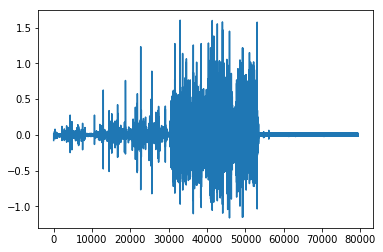

In [16]:
# Illustrate data to determine if it needs to be windowed.

if len(data.shape)==2:
    plt.figure()
    plt.plot(data.iloc[:,0], data.iloc[:,3])
    #plt.ylim([-1,1])
    plt.show()

In [22]:
window_data = True
if(window_data):
    ## Window data if recorded over time

    window = [0, 52500]

    data = data[(data.Time > min(window)) & (data.Time <= max(window))]
    data.reset_index(drop=True, inplace=True)

## Dataset Features
Calculate features of the dataset that will allow it to be compared with other datasets.
* Peaks ~ the maximum G value in each event across all rows in each column.
* Mean ~ the average G value in each event across all rows in each column.
* 3Sig_max/min ~ The max and min value 3 sigma for each column across rows and events.

In [23]:
## Features

def vib_peaks (data, th=1):
    ## Find impacts over a threshhold.
    '''
    Assume data is of the form [Time, R1, R2, ... , Rn], where n is the number of response 
    columns in the file.
    
    th ~ Threshold [G] over which peaks are recorded.
    The threshold value is only required when recording over time.  When recording impacts 
    '''
    if len(data.shape) == 3:
        peaks = abs(data[:,:,1:]).max(axis=1).T
        mean = data[:,:,1:].mean(axis=1).T
    elif len(data.shape) == 2:
        peaks = data.iloc[sp.any(data.iloc[:,1:] > th, axis=1),1:]
        mean = data.iloc[:,1:].mean(axis=0)
    else:
        print('Unknown input data dimension')
    
    
    return peaks, mean

def sigma_calc(data, degree):
    '''
    Calculates sigma of a set of values to a requested degree, i.e. 6 Sigma
    
    Input values can have as many columns as wanted.  The calculation will
    be performed across the rows.
    
    If a pandas Panel or 3D array is input, calculation will be performed 
    across the rows and depth.
    
    Returns:
    [sigma1, sigma2, ..., sigman] for n columns of values input. 
    '''
    
    mean = sp.mean(data, axis=0)
    std = sp.std(data, axis=0, ddof=1)
    
    for i in range(len(sp.shape(data))-2):
        mean = sp.mean(mean, axis=0)
        std = sp.std(std, axis=0, ddof=1)
    
    sig_plus = mean + degree * std
    sig_minus = mean - degree * std
    
    return(sig_plus, sig_minus)


In [24]:
th = 0.5    # Threshhold, [G]
peaks, mean = vib_peaks(data, th)
sig3_max, sig3_min = sigma_calc(peaks, 3)

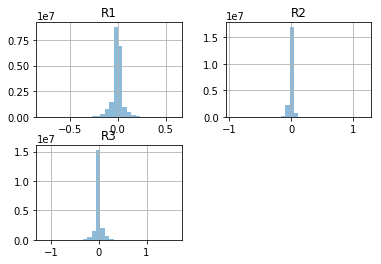

In [25]:
# Illustrate results to see if they are in line with what we expect.

if len(data.shape)==2:
    data.iloc[:,1:].hist(bins=30, normed=0, alpha=0.5)
    plt.show()

## Vibration Profiles, Standard

Allow the user to recall the input PSD profile.  Common profiles are
saved in vib_profiles.csv.

User can also recall a previously saved .csv file.

In [26]:
def vib_profiles(profile):
    '''
    Given a correct vibration profile, returns the profile with two
    columns.  [freq, psd]
    
    If profile is a .csv file, returns a previously saved file.
    '''
    vibls = pd.read_csv('vib_profiles.csv')

    input_profile = 0
    for i in range(sp.shape(vibls)[1]):
        if vibls.columns[i].upper() == profile.upper():
            input_profile = vibls.iloc[:,i:i+2].dropna()
            #input_profile = input_profile.dropna()
            input_profile.columns = ['Freq', 'PSD']
            return(input_profile)
    
    if profile[-4:].upper() == '.csv'.upper():
        input_profile = pd.read_csv(profile) 
        return(input_profile)
    
    if type(input_profile) == int:
        print('Input vibration profile not found')
        input_profile = False
    
    return(input_profile)

# Input Profile Label defined at the top
input_profile = vib_profiles(input_profile_label)

In [105]:
N

20264964

In [108]:
maxT = int(floor(max(data.Time)))

# Initialize the minimum sample length of all events
samp_min = maxT

# Time Step
dt = float(data.Time[2] - data.Time[1])

fs = float(1./dt)                                # Sampling Frequency
N = int(len(data.Time))                       # Number of Samples
sig_len = N/fs                                   # Signal Length [s]
df = 1/sig_len

f, psd = welch(data.iloc[:,1:], fs = fs, nperseg = N, axis=0)
data_psd = sp.zeros((psd.shape[0], psd.shape[1]+1))
f_psd = f*sp.ones((len(psd), len(f)))
data_psd = sp.concatenate((f_psd[...,None], psd), axis=2)

MemoryError: 

In [95]:
f_psd.shape

(20264964, 2)

In [90]:
psd.shape

(20264964, 2)

## Calculate FFT and PSD
Need to determine if the input is a single file, collection of short responses, or a long recording.  If the response is a long recording, I need to break it down and average the results.

In [82]:
def fft_data(data):
    dt = float(data.E0.Time[1] - data.E0.Time[0])    # Time Steps, [s]
    fs = float(1./dt)                                # Sampling Frequency
    N = int(len(data.E0.Time))                       # Number of Samples
    sig_len = N/fs                                   # Signal Length [s]
    df = 1/sig_len

    ## FFT, basic
    freq = df*sp.arange(0, N, dtype='d')
    data_fft = sp.fft(data[:,:,1:])
    f_fft = freq*sp.ones((len(data_fft), len(freq)))
    data_fft = sp.concatenate((f_fft[...,None], data_fft), axis=2)
    #fft_avg = sp.mean(data_fft, axis=0)
    
    ## PSD, basic
    f, psd = welch(data[:,:,1:], fs = fs, nperseg = N, axis=1)
    data_psd = sp.zeros((psd.shape[0], psd.shape[1], psd.shape[2]+1))
    f_psd = f*sp.ones((len(psd), len(f)))
    data_psd = sp.concatenate((f_psd[...,None], psd), axis=2)
    
    return(data_fft, data_psd)

def fft_dataS(data):
    tic = time.clock()
    
    # Maximum Time to consider data, will remove any data past
    # the last whole second
    maxT = int(floor(max(data.Time)))

    # Initialize the minimum sample length of all events
    samp_min = maxT

    # Time Step
    dt = float(data.Time[2] - data.Time[1])
    
    fs = float(1./dt)                                # Sampling Frequency
    N = int(len(data.Time))                       # Number of Samples
    sig_len = N/fs                                   # Signal Length [s]
    df = 1/sig_len
    
    ## FFT, basic
    freq = df*sp.arange(0, N, dtype='d')
    data_fft = sp.fft(data.iloc[:,1:])
    f_fft = freq*sp.ones((len(data_fft), len(freq)))
    data_fft = sp.concatenate((f_fft[...,None], data_fft), axis=2)
    #fft_avg = sp.mean(data_fft, axis=0)
    
    ## PSD, basic
    f, psd = welch(data.iloc[:,1:], fs = fs, nperseg = N, axis=1)
    data_psd = sp.zeros((psd.shape[0], psd.shape[1], psd.shape[2]+1))
    f_psd = f*sp.ones((len(psd), len(f)))
    data_psd = sp.concatenate((f_psd[...,None], psd), axis=2)
    
    return(data_fft, data_psd)


if len(data.shape) == 2 and max(data.Time) > 2:
    data_fft, data_psd = fft_dataS(data)
else:    
    data_fft, data_psd = fft_data(data)

## !? Converting data_psd to a Panda's dataframe takes a very long time.
## I can convert the average below though.






MemoryError: 

20264964

In [ ]:
## Plot the average PSD response
avg_psd = sp.array([[sp.mean(data_psd[:,i,j]) for j in range(len(data_psd[0,0,:]))] for i in range(len(data_psd[0,:,0]))])
max_psd = sp.array([[max(abs(data_psd[:,i,j])) for j in range(len(data_psd[0,0,:]))] for i in range(len(data_psd[0,:,0]))])
min_psd = sp.array([[min(abs(data_psd[:,i,j])) for j in range(len(data_psd[0,0,:]))] for i in range(len(data_psd[0,:,0]))])

if avg_psd.shape[1] == 4:
    avg_psd = pd.DataFrame(avg_psd, columns=('Freq', 'X', 'Y', 'Z'))
    max_psd = pd.DataFrame(max_psd, columns=('Freq', 'X', 'Y', 'Z'))
    min_psd = pd.DataFrame(min_psd, columns=('Freq', 'X', 'Y', 'Z'))
else:
    headers = ['Freq']
    for i in range (avg_psd.shape[1]-1):
        headers.append(('R%i' %(i)))
        
    avg_psd = pd.DataFrame(avg_psd, columns=headers)
    max_psd = pd.DataFrame(max_psd, columns=headers)
    min_psd = pd.DataFrame(min_psd, columns=headers)
    
if(1):    
    ## Print Average PSD Results
    plt.figure('PSD')
    esi_truck_profile = vib_profiles('ista air ride')
    plt.loglog(esi_truck_profile.Freq, esi_truck_profile.PSD, 'k', label='Input')
    plt.loglog(avg_psd.Freq, avg_psd.X, 'b', label='X')
    plt.loglog(avg_psd.Freq, avg_psd.Y, 'r', label='Y')
    plt.loglog(avg_psd.Freq, avg_psd.Z, 'g', label='Z')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [G^2/Hz]')
    plt.title('PSD Response')
    plt.axis([1,200,1e-6, 1e-1])

    plt.show()

In [49]:
def single2Panel(data):
    
    '''
    Converts a single sample of length greater then 2 seconds to a
    pandas Panel set of 1 second events.

    If data is already a series of events or to short, returns the
    input.
    '''
    pd.options.mode.chained_assignment = None  # default='warn'

    if len(data.shape) == 2 and max(data.Time) > 2:

        tic = time.clock()

        # Maximum Time to consider data, will remove any data past
        # the last whole second
        maxT = int(floor(max(data.Time)))

        # Initialize the minimum sample length of all events
        samp_min = maxT

        # Time Step
        dt = float(data.Time[2] - data.Time[1])

        # Break the data up into seconds
        dataS = {}
        dataS = sp.empty(maxT)
        for i in trange(maxT-1):
            # tqdm adds a progress bar
            # trange(i) is a special optimised instance of tqdm(range(i))

            name = 'E' + str(i)
            dataS[name] = data[(data.Time > float(i)) & (data.Time < float(i+1))]

            # Set the time to be the same across all events
            dataS[name].Time.iloc[0] = 0
            for j in range(len(dataS[name])-1):
                dataS[name].Time.iloc[j+1] = dataS[name].Time.iloc[j] + dt

            # Reduce mem. use by converting to float32
            dataS[name] = dataS[name].astype('float32')

            # Determine if this event has the fewest samples
            if len(dataS[name])<samp_min: samp_min = len(dataS[name])

        #dataS = pd.Panel(dataS)

        # Set all events to the same sample length
        #dataS = dataS[:,0:samp_min-1,:]

        toc = time.clock()

        print('# Events: %i' %len(dataS))
        print('# Samples per Event: %i' %samp_min)
        print('Time to collect and filter data: %.1f [s]' %(toc-tic))

        return dataS

    else:
        print('Dataset to small to seperate.')
        return dataS


In [48]:
# Notes

if(0):
    maxT = int(floor(max(data.Time)))                # Total Time, # of seconds
    dt = float(data.Time[2] - data.Time[1])          # Time Step, [s]
    fs = float(1./dt)                                # Sampling Frequency, [Hz]
    N = int(data0.shape[-2])                         # Number of Samples 
    sig_len = N/fs                                   # Signal Length, [s]
    df = 1/sig_len                                   # Frequency step, [Hz]

    step = floor(1/dt)
    rowN = data.shape[-2]
    colN = data.shape[-1]
    events = floor(rowN/step)

    data0 = sp.empty((events, step-1, colN))

    for i in trange(events):
        data0[i, :, : ] = data[:][i*step:((i+1)*step-1)][:]

    

In [37]:
## Calculating the Grms of a shaped random vibration input curve.
# Sec. 8.8, Eqns. 8.4 - 8.6.

def grms (freq, PSD):
    """Returns the Grms value for a shaped random vibration input curve.
    Input the frequency and PSD values as a list in the form grms(freq, PSD).
    The frequency and PSD list must have the same number of elements."""
    
    from math import log10, log
    
    A = 0
    
    if len(freq)!=len(PSD):
        print("Error: The number of elements in the Frequency and PSD lists do not match.")
    
    else:
        for i in range(1,len(freq)):
            
            # Calculate the slope
            dB = 10 * log10(PSD[i]/PSD[i-1])           # dB
            OCT = log10(freq[i]/freq[i-1])/log10(2)    # Octave
            S = dB/OCT                                 # Slope
            
            # Calculate the area in units of [G^2]
            if S == 0:
                A = A + PSD[i] * (freq[i] - freq[i-1])
            elif S == -3:
                A = A + -freq[i] * PSD[i] * log(freq[i-1] / freq[i])
            else:
                A = A + (3 * PSD[i]/(3 + S)) * (freq[i] - (freq[i-1]/freq[i])**(S/3) * freq[i-1])
            
            # Calculate the Grms [G]
            grms = A**(0.5)

    return(grms)

In [38]:
## Interpolate values of one profile across frequency range of another response.
def vib_trans(resp, profile):
    
    """
    Interpolate the values of the profile across the frequency range of the response.  The profile consists
    of two lists, a frequency and amplitude.  The response consists of the same.  This program finds the amplitudes
    of the profile at the frequencies of the response.  This allows you to compare the amplitudes of the response 
    and the profile at the same frequencies.
    
    resp = [frequency, amplitude]
    profile = [frequency, amplitude]
    
    Returns the transmissibility results Respose / Input Profile.
    
    return([frequency, transmissibility amplitude])
    """
    
    
    
    # The number of axis or recordings over which to 
    num_resp = min([resp.shape[1], profile.shape[1]])-1
    
    transo = []
    cols = ['Freq']
    
    for k in range(num_resp):
        m0 = []          # Finding the slope of the input profile
        for i in range(profile.shape[0]-1):
            m0.append((log10(profile.iloc[i+1,k+1])-log10(profile.iloc[i,k+1]))/(log10(profile.Freq[i+1])-log10(profile.Freq[i])))

        freq = []        # Initialize the frequency variable
        resp_c = []      # Initialize the clipped response variable
        m = []           # Initialize the slope variable
        x1 = []          # Initialize the frequency used in the point slope equation
        y1 = []          # Initialize the amplitude used in the point slope equation

        # Find the frequencies and response where which lie within the profile frequency range
        for i in trange(len(resp.Freq)):
            if resp.Freq[i] >= float(min(profile.Freq)) and resp.Freq[i] < float(max(profile.Freq)):
                freq.append(resp.Freq[i])
                resp_c.append(resp.iloc[i, k+1])
            for j in range(profile.shape[0]-1):
                if resp.Freq[i] < profile.Freq[j+1] and resp.Freq[i] >= profile.Freq[j]:
                    m.append(m0[j])
                    x1.append(profile.iloc[j+1,0])
                    y1.append(profile.iloc[j+1,k+1])

        # Make sure the slope is recording across the appropriate values.
        if len(m)!= len(freq):
            print('Error finding slope, len(m) != len(freq)')
            print('len m = %i' %len(m))
            print('len freq = %i' %len(freq))

        resp_int = []                 # Initializing the interpolated response variable.
        # Calculating the interpolated response given the slope and input profile point
        for i in range(len(freq)):
            resp_int.append(10**(m[i]*(log10(freq[i])-log10(x1[i])) + log10(y1[i])))

        # Converting the list to an array
        resp_int = sp.array(resp_int)
        resp_c = sp.array(resp_c)

        ## From Steinberg 1988
        # P_out = Q^2 * P
        # Solving for Q ->
        trans = (resp_c/resp_int)**0.5    # Q ~ Transmissibility of system
        
        if len(transo) == 0:
            transo = sp.array((trans), ndmin=2).T
        else:
            transo = sp.concatenate((transo, sp.array((trans), ndmin=2).T), axis=1)
        
        cols.append('R%i' %k)
    
    return(pd.DataFrame((sp.concatenate((sp.array((freq), ndmin=2).T, transo), axis=1)), columns=cols))

# Input profile label defined at the top
# If the input profile is a .csv file, it should contain multiple axis.  If not, 
# the standard profiles are just over one axis (Z).  This may not be true in the
# future and I should create a test to generalize the input and standard profiles.

if input_profile_label[-4:] == '.csv':
    trans = vib_trans(avg_psd, input_profile)
else:
    trans = vib_trans(avg_psd.iloc[:,[0,3]], input_profile)



NameError: name 'avg_psd' is not defined

In [51]:
def data_to_hist(peaks):

    ## Histogram of the peak impacts from the vibration data    
    sig3_max, sig3_min = sigma_calc(peaks, 3)
    
    pkx = peaks.X
    pky = peaks.Y
    pkz = peaks.Z

    # Plot Results
    plt.figure('Histogram', figsize=(8,8))
    #plt.title('Histogram of Peak Impacts On Each Axis')
    
    # Combined results
    plt.subplot(2,2,1)
    nz, binsz, patchesz = plt.hist(pkz, 30, normed=0, facecolor='green', alpha=0.50, label='Z')
    ny, binsy, patchesy = plt.hist(pky, 30, normed=0, facecolor='red', alpha=0.50, label='Y')
    nx, binsx, patchesx = plt.hist(pkx, 30, normed=0, facecolor='blue', alpha=0.50, label='X')
    
    plt.xlabel('Peak Acceleration [G]')
    plt.ylabel('Probability')
    plt.legend(loc='upper right', fontsize = 'small')
    plt.xlim(xmin=0)

    plt.grid(True)
    
    # Z Axis
    plt.subplot(2,2,2)
    nz, binsz, patchesz = plt.hist(pkz, 30, normed=0, facecolor='green', alpha=0.50)
    plt.plot((sp.mean(pkz),sp.mean(pkz)), (0, max(nz)), 'k--', linewidth=2, label=('Mean (%.2f)' % sp.mean(pkz)))
    plt.plot((sig3_max.Z,sig3_max.Z), (0, max(nz)), 'k-.', linewidth=2, label=('3$\sigma$ (%.2f - %.2f)' %(sig3_min.Z, sig3_max.Z)))
    plt.plot((sig3_min.Z,sig3_min.Z), (0, max(nz)), 'k-.', linewidth=2)
    plt.legend(loc='upper right', fontsize='small')
    plt.xlim(xmin=0)
    plt.grid(True)
    
    # X Axis
    plt.subplot(2,2,3)
    nx, binsx, patchesx = plt.hist(pkx, 30, normed=0, facecolor='blue', alpha=0.50)
    plt.plot((sp.mean(pkx),sp.mean(pkx)), (0, max(nx)), 'k--', linewidth=2, label=('Mean (%.2f)' % sp.mean(pkx)))
    plt.plot((sig3_max.X,sig3_max.X), (0, max(nx)), 'k-.', linewidth=2, label=('3$\sigma$ (%.2f - %.2f)' %(sig3_min.X, sig3_max.X)))
    plt.plot((sig3_min.X,sig3_min.X), (0, max(nx)), 'k-.', linewidth=2)
    plt.legend(loc='upper right', fontsize='small')
    
    plt.xlabel('Peak Acceleration [G]')
    plt.ylabel('Probability')
    plt.xlim(xmin=0)
    plt.grid(True)
    
    # Y Axis
    plt.subplot(2,2,4)
    ny, binsy, patchesy = plt.hist(pky, 30, normed=0, facecolor='red', alpha=0.50)
    plt.plot((sp.mean(pky),sp.mean(pky)), (0, max(ny)), 'k--', linewidth=2, label=('Mean (%.2f)' % sp.mean(pky)))
    plt.plot((sig3_max.Y,sig3_max.Y), (0, max(ny)), 'k-.', linewidth=2, label=('3$\sigma$ (%.2f - %.2f)' %(sig3_min.Y, sig3_max.Y)))
    plt.plot((sig3_min.Y,sig3_min.Y), (0, max(ny)), 'k-.', linewidth=2)
    plt.legend(loc='upper right', fontsize='small')
    
    plt.xlabel('Peak Acceleration [G]')
    plt.xlim(xmin=0)
    plt.grid(True)

    #add a best fit line curve
    #y = mlab.normpdf(bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=1)
    
    plt.savefig('hist_data')
    plt.show()

In [52]:
grms(avg_psd.Freq, avg_psd.Y)

0.071177884180333301

In [53]:
input_profile.shape[1]

4

The input GRMS is :
 X : 0.07,  Y : 0.06,  Z : 0.31 [G]
The response GRMS is :
 X : 0.08,  Y : 0.07,  Z : 0.08 [G]
Out of 432 events, the maximum impacts are 
 X : 0.61,  Y : 0.83,  Z : 0.77 [G]
The average peak impacts by axis are 
 X : 0.25,  Y : 0.22,  Z : 0.21 [G]
The 3 sigma values are 
 X : 0.47,  Y : 0.44,  Z : 0.45 [G]


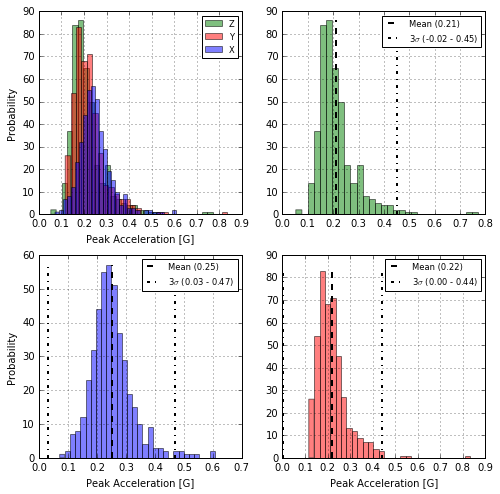

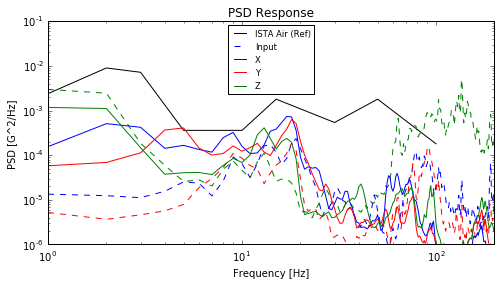

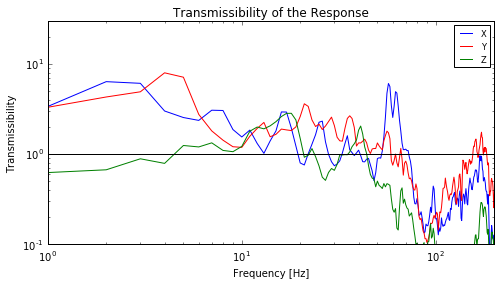

In [54]:
## Print results from the data above

if (input_profile.shape[1] == 4):
    print("The input GRMS is :\n",
          "X : %.2f,  Y : %.2f,  Z : %.2f [G]" %((grms(input_profile.iloc[:,0],input_profile.iloc[:,1])),
                                                 (grms(input_profile.iloc[:,0],input_profile.iloc[:,2])), 
                                                 (grms(input_profile.iloc[:,0],input_profile.iloc[:,3]))))

    print("The response GRMS is :\n",
        "X : %.2f,  Y : %.2f,  Z : %.2f [G]" %(grms(avg_psd.Freq, avg_psd.X),
                                               grms(avg_psd.Freq, avg_psd.Y), 
                                               grms(avg_psd.Freq, avg_psd.Z)))
else:
    print("The input GRMS is : %.2f" %(grms(input_profile.iloc[:,0],input_profile.iloc[:,1])))
    
    print("The response GRMS is : %.2f" %grms(avg_psd.Freq, avg_psd.Z))
    
print("Out of %i events, the maximum impacts are \n" %(data.shape[0]),
      "X : %.2f,  Y : %.2f,  Z : %.2f [G]" %(max(peaks.X), max(peaks.Y), max(peaks.Z)))
print('The average peak impacts by axis are \n',
     "X : %.2f,  Y : %.2f,  Z : %.2f [G]" %(sp.mean(peaks.X), sp.mean(peaks.Y), sp.mean(peaks.Z)))

print('The 3 sigma values are \n',
      "X : %.2f,  Y : %.2f,  Z : %.2f [G]" 
      %(sig3_max.X, sig3_max.Y, sig3_max.Z))

data_to_hist(peaks)

# Pull reference curve for illustration
ista_air = vib_profiles('ista air ride')

plt.figure('PSD', figsize=(8,4))
if trans.shape[1]>2:
    plt.loglog(ista_air.Freq, ista_air.PSD, 'k', label='ISTA Air (Ref)')
    plt.loglog(input_profile.Freq, input_profile.X, '--b', label='Input')
    plt.loglog(input_profile.Freq, input_profile.Y, '--r', label='')
    plt.loglog(input_profile.Freq, input_profile.Z, '--g', label='')
    plt.loglog(avg_psd.Freq, avg_psd.X, 'b', label='X')
    plt.loglog(avg_psd.Freq, avg_psd.Y, 'r', label='Y')
    plt.loglog(avg_psd.Freq, avg_psd.Z, 'g', label='Z')
else:
    psdin = input_profile
    plt.figure()
    plt.loglog(ista_air.Freq, ista_air.PSD, '--k', label='ISTA Air (Ref)')
    plt.loglog(psdin.Freq, psdin.PSD, 'k', label='Input')
    plt.loglog(avg_psd.Freq, avg_psd.X, 'b', label='X')
    plt.loglog(avg_psd.Freq, avg_psd.Y, 'r', label='Y')
    plt.loglog(avg_psd.Freq, avg_psd.Z, 'g', label='Z')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [G^2/Hz]')
plt.title('PSD Response')
plt.legend(loc='best', fontsize='small')
plt.axis([1,200,1e-6, 1e-1])
plt.savefig('psd')
plt.show()

plt.figure('Trans', figsize=(8,4))
if trans.shape[1]<=2:
    plt.loglog(trans.Freq, trans.R0, 'g', label='Z')
if trans.shape[1]>2:
    plt.loglog(trans.Freq, trans.R0, 'b', label='X')
    plt.loglog(trans.Freq, trans.R1, 'r', label='Y')
    plt.loglog(trans.Freq, trans.R2, 'g', label='Z')
plt.legend(loc='best', fontsize='small')
plt.loglog([1, 200], [1, 1], 'k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Transmissibility')
plt.title('Transmissibility of the Response')
plt.axis([1,200,0.1,30])
plt.savefig('trans')
plt.show()

In [55]:
# Save the psd response to file if it is the input of other responses.
# This will allow for the transmissibility to be calculated.

# save_csv and save_csv_title defined at top

if save_csv:
    avg_psd.to_csv('profiles/'+save_csv_title, index=False)


if 0:
    import csv
    
    ofile = open('profiles/'+save_csv_title, 'w')
    
    writer = csv.writer(ofile, lineterminator = '\n')
    
    for row in avg_psd:
        writer.writerow(row)
    
    ofile.close()
    
    
    

In [56]:
print('test [%s]' %input_profile_label)

test [profiles/lattice_20170307-test2_logger0.csv]


In [57]:
## Create a report

# Title defined at top

doc = docx.Document()

doc.add_heading('Shock and Vibration Testing', 0)
doc.add_heading(title,1)

if input_profile.shape[1]<=2:
    doc.add_paragraph(text ="\nThe input GRMS is : %.3f [%s]\nThe response GRMS is : %.3f\n" 
                  %((grms(input_profile.Freq, input_profile.iloc[:,1])), 
                    input_profile_label, grms(avg_psd.Freq, avg_psd.Z)))
else:
    doc.add_paragraph(text ="\nThe input GRMS is : \nX : %.3f,  Y : %.3f,  Z : %.3f [g^2/Hz] [%s]"
                                %((grms(input_profile.iloc[:,0],input_profile.iloc[:,1])),
                                 (grms(input_profile.iloc[:,0],input_profile.iloc[:,2])), 
                                 (grms(input_profile.iloc[:,0],input_profile.iloc[:,3])), 
                                 input_profile_label))
    doc.add_paragraph(text ="The response GRMS is : \nX : %.3f,  Y : %.3f,  Z : %.3f [g^2/Hz]\n"
                      %(grms(avg_psd.Freq, avg_psd.X),
                                 grms(avg_psd.Freq, avg_psd.Y), 
                                 grms(avg_psd.Freq, avg_psd.Z)))

    
doc.add_paragraph(('''Out of %i events, the maximum impacts are:
X : %.2f,  Y : %.2f,  Z : %.2f [G]\n''') 
                  %(data.shape[0], max(peaks.X), max(peaks.Y), max(peaks.Z)))
      
doc.add_paragraph('''The average peak impact by axis are:
X : %.2f,  Y : %.2f,  Z : %.2f [G]\n''' 
                  %(sp.mean(peaks.X), sp.mean(peaks.Y), sp.mean(peaks.Z)))

doc.add_paragraph('''The 3 sigma values are:
X : %.2f,  Y : %.2f,  Z : %.2f [G]\n\n''' %(sig3_max.X, sig3_max.Y, sig3_max.Z))

doc.add_picture('psd.png', width=docx.shared.Inches(6), height=docx.shared.Inches(4))

#doc.paragraphs[6].runs[0].add_break(docx.enum.text.WD_BREAK.PAGE)

doc.add_picture('trans.png', width=docx.shared.Inches(6), height=docx.shared.Inches(2.5))

doc.add_paragraph('\nHistogram showing the peak impact accelerations and their frequency:')

doc.add_picture('hist_data.png', width=docx.shared.Inches(6), height=docx.shared.Inches(5))


# save_title defined at top
doc.save('reports/'+save_doc_title)